In [1]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm

from dojo.utils import save_transform

/home/amar/miniconda3/envs/jivi-ass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Find patterns in images

In [12]:
images_dir = "/home/amar/dev/work/projects/dojo/data/raw/train"

all_fpaths = []
for root, dnames, fnames in os.walk(images_dir):
    fpaths = [os.path.join(root, f) for f in fnames]
    all_fpaths.extend(fpaths)

In [13]:
all_fpaths = random.sample(all_fpaths, 100)
print(f"{all_fpaths[:10] = }")

all_fpaths[:10] = ['/home/amar/dev/work/projects/dojo/data/raw/train/cataract/image_116.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_125.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_221.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_202.png', '/home/amar/dev/work/projects/dojo/data/raw/train/cataract/image_33.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_193.png', '/home/amar/dev/work/projects/dojo/data/raw/train/cataract/image_45.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_71.png', '/home/amar/dev/work/projects/dojo/data/raw/train/normal/image_205.png', '/home/amar/dev/work/projects/dojo/data/raw/train/cataract/image_109.png']


In [14]:
import open_clip
import torch
from PIL import Image

model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
model.eval()
tokenizer = open_clip.get_tokenizer("ViT-B-32")

index_to_fpath = {}
image_features_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for i, fpath in tqdm(enumerate(all_fpaths), total=len(all_fpaths)):
        image = preprocess(Image.open(fpath)).unsqueeze(0)
        image_features = model.encode_image(image)
        image_features_list.append(image_features)
        index_to_fpath[i] = fpath

image_features = torch.stack(image_features_list).cpu().numpy()
image_features = image_features.squeeze()
print(f"{image_features.shape = }")

/home/amar/miniconda3/envs/jivi-ass/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_p

image_features.shape = (100, 512)


In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=5)
image_features_pca = pca.fit_transform(image_features)
print(image_features_pca.shape)

tsne = TSNE(n_components=2, random_state=42)
image_features_tsne = tsne.fit_transform(image_features)
print(f"{image_features_tsne.shape = }")

(100, 5)
image_features_tsne.shape = (100, 2)


100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


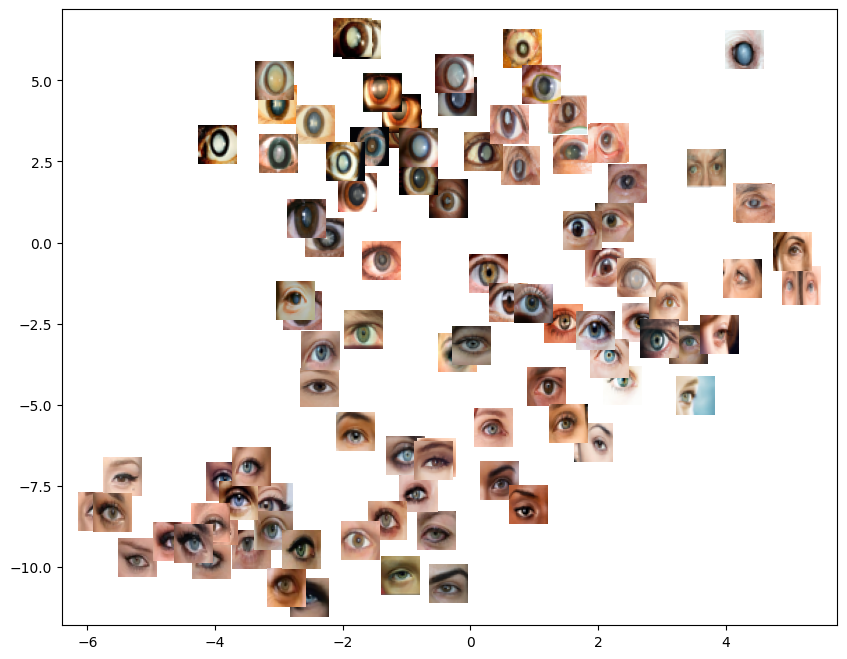

In [16]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

plt.figure(figsize=(10, 8))
ax = plt.gca()
# plt.scatter(image_features_pca[:, 1], image_features_pca[:, 3], alpha=0.7)
plt.scatter(image_features_tsne[:, 0], image_features_tsne[:, 1], alpha=0.7)


def get_image(path):
    image = Image.open(path).resize((28, 28))
    return OffsetImage(np.array(image), zoom=1)


# for i in tqdm(range(len(image_features_pca)), total=len(image_features_pca)):
for i in tqdm(range(len(image_features_tsne)), total=len(image_features_tsne)):
    image_path = index_to_fpath[i]
    image = get_image(image_path)
    # ab = AnnotationBbox(image, (image_features_pca[i, 0], image_features_pca[i, 1]), frameon=False)
    ab = AnnotationBbox(image, (image_features_tsne[i, 0], image_features_tsne[i, 1]), frameon=False)
    ax.add_artist(ab)

# plt.title('PCA of Image Features')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
plt.grid(False)
plt.show()

# Vizualize transforms

In [2]:
transform = A.Compose(
    [
        A.LongestMaxSize(max_size=256),
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
        A.ToFloat(),
        A.Blur(blur_limit=3),
        # A.ColorJitter(),  # Had to remove this because the images were too unrealistic
        A.RandomBrightnessContrast(),
        A.Defocus(radius=(3, 5), alias_blur=(0.1, 0.3)),
        A.ImageCompression(quality_lower=60, quality_upper=100),
        A.ToGray(p=0.1),  # Not too sure about this augmentation
        # A.ToRGB(),
        A.HorizontalFlip(),
    ]
)

transform

Compose([
  LongestMaxSize(always_apply=False, p=1, max_size=256, interpolation=1),
  RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  ToFloat(always_apply=False, p=1.0, max_value=None),
  Blur(always_apply=False, p=0.5, blur_limit=(3, 3)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  Defocus(always_apply=False, p=0.5, radius=(3, 5), alias_blur=(0.1, 0.3)),
  ImageCompression(always_apply=False, p=0.5, quality_lower=60, quality_upper=100, compression_type=0),
  ToGray(always_apply=False, p=0.1),
  HorizontalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [3]:
train_dir = "/home/amar/dev/work/projects/dojo/data/raw/train"
class_to_fpaths = dict()

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)

    for root, _, fnames in os.walk(class_dir):
        fpaths = [os.path.join(root, fname) for fname in fnames]
        class_to_fpaths[classname] = fpaths

print(class_to_fpaths.keys())

dict_keys(['cataract', 'normal'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4436472e-16..0.7724999].


Class: cataract


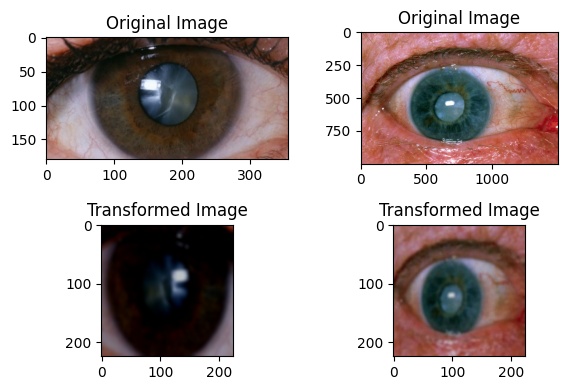

Class: normal


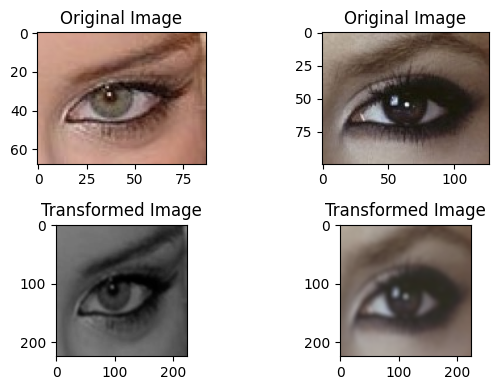

In [9]:
for classname, fpaths in class_to_fpaths.items():
    random_fpaths = random.sample(fpaths, 2)
    print(f"Class: {classname}")

    fig, axs = plt.subplots(2, len(random_fpaths), figsize=(len(random_fpaths) * 3, 4))

    for i, fpath in enumerate(random_fpaths):
        image = np.array(Image.open(fpath))
        axs[0, i].imshow(image)
        axs[0, i].set_title("Original Image")

        transformed_image = transform(image=image)["image"]
        axs[1, i].imshow(transformed_image)
        axs[1, i].set_title("Transformed Image")

        # imshow(transformed_image)
    plt.tight_layout()
    plt.show()

In [10]:
final_transform = A.Compose(
    [
        transform,
        ToTensorV2(),
    ]
)

In [11]:
save_transform(
    final_transform,
    "/home/amar/dev/work/projects/dojo/conf/transform/default.yaml",
)

# Patterns noted
1. The model might be biased towards predicting female eyes as normal and other kind of eyes as cataract because there seems to be an over representation of females pictures in normal folder
2. Camera distance seems to be a big factor, cataract images are clicked from much closer and clinically while non cataract folder seems to be crops from full face images